# Neural Network Modelling for Glacier Mass Balance Prediction

This notebook implements **neural network models** for predicting glacier point mass balance measurements using meteorological and topographical features. The notebook supports two main modelling approaches:

##  **Modelling Strategies**

### 1. **Regional Modelling (Norway Only)**
- Train and test exclusively on Norwegian glacier data
- Uses glacier-based train/test splits to ensure spatial generalization

### 2. **Cross-Regional Modelling (Switzerland → Norway)**
- Combines data from Swiss glaciers and Norway glaciers
- Can be used as either a cross-regional model, training exclusively on Swiss data and testing on Norwegian data
- or as a baseline for transfer learning models, training on Swiss data and a subset of Norwegian data and testing on remaining Norwegian data

##  **Technical Features**
- **Flexible neural network architecture** with configurable layers and dropout
- **Aggregated predictions** by measurement ID for robust evaluation
- **Comprehensive evaluation metrics** (MAE, RMSE, Pearson correlation)
- **Visualizations** for model performance analysis
- **Model checkpointing** and reproducible training

---

##  **Prerequisites**
- Norwegian glacier dataset from `../1.1. Norway-prepro.ipynb`
- Swiss glacier dataset from `regions/Switzerland/1.1. GLAMOS-prepro.ipynb`
- ERA5 climate data for both regions from `../1.2. ERA5Land-prepro.ipynb`
---

## Environment Setup & Configuration

In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../../')) # Add root of repo to import MBM

import pandas as pd
import warnings
from tqdm.notebook import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging
import torch.nn as nn
from skorch.helper import SliceDataset
from datetime import datetime
from skorch.callbacks import EarlyStopping, LRScheduler, Checkpoint
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset
import pickle 

from scripts.helpers import *
from scripts.norway_preprocess import *
from scripts.plots import *
from scripts.config_NOR import *
from scripts.nn_helpers import *
from scripts.xgb_helpers import *
from scripts.NN_networks import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

cfg = mbm.NorwayConfig(dataPath='/home/mburlet/scratch/data/DATA_MB/WGMS/Norway/')

In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect", # OGGM
    "slope", # OGGM
    "hugonnet_dhdt",  # OGGM
    "consensus_ice_thickness",  # OGGM
    "millan_v",
]

In [3]:
seed_all(cfg.seed)

if torch.cuda.is_available():
    print("CUDA is available")
    free_up_cuda()

    # # Try to limit CPU usage of random search
    # torch.set_num_threads(2)  # or 1
    # os.environ["OMP_NUM_THREADS"] = "1"
    # os.environ["MKL_NUM_THREADS"] = "1"
else:
    print("CUDA is NOT available")


CUDA is available


### Feature Definitions & Hardware Configuration

**Climate Features (ERA5 Reanalysis):**
- `t2m`: 2-meter temperature - key driver of melt processes
- `tp`: Total precipitation - determines accumulation patterns  
- `slhf`/`sshf`: Surface heat fluxes - control energy balance
- `ssrd`: Solar radiation - primary melt energy source
- `fal`: Albedo - surface reflectivity affecting melt
- `str`: Thermal radiation - longwave energy component
- `u10`/`v10`: Wind components - affect heat/moisture transport

**Topographical Features (OGGM):**
- `aspect`/`slope`: Terrain geometry affecting radiation exposure
- `hugonnet_dhdt`: Ice thickness changes from satellite observations
- `consensus_ice_thickness`: Modeled ice depth distribution
- `millan_v`: Ice surface velocity from satellite measurements

The system automatically detects CUDA availability for GPU acceleration during neural network training.

## A. Regional Modelling (Norway Only)

This approach trains neural networks exclusively on Norwegian glacier data.

## Data Loading & Initial Processing

### Create Norwegian Glacier Dataset

Start with point mass balance measurements and transform them to monthly format with ERA5 climate data.

In [4]:
data_wgms = pd.read_csv(cfg.dataPath + path_PMB_WGMS_csv + 'Nor_dataset_all_oggm_with_millanv.csv')
# Drop Nan entries in millan_v of Norway dataset
data_wgms = data_wgms.dropna(subset=data_wgms.columns.drop('DATA_MODIFICATION'))

print('Number of glaciers:', len(data_wgms['GLACIER'].unique()))
print('Number of winter, summer and annual samples:', len(data_wgms[data_wgms.PERIOD == 'annual']) + len(data_wgms[data_wgms.PERIOD == 'winter']) + len(data_wgms[data_wgms.PERIOD == 'summer']))
print('Number of annual samples:',
      len(data_wgms[data_wgms.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_wgms[data_wgms.PERIOD == 'winter']))
print('Number of summer samples:',
      len(data_wgms[data_wgms.PERIOD == 'summer']))

data_wgms.columns


Number of glaciers: 31
Number of winter, summer and annual samples: 5959
Number of annual samples: 3022
Number of winter samples: 2937
Number of summer samples: 0


Index(['POINT_LAT', 'POINT_LON', 'POINT_ELEVATION', 'FROM_DATE', 'TO_DATE',
       'POINT_BALANCE', 'PERIOD', 'RGIId', 'YEAR', 'GLACIER',
       'DATA_MODIFICATION', 'POINT_ID', 'aspect', 'slope', 'topo',
       'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v'],
      dtype='object')

In [5]:
data_wgms_test = data_wgms.copy()

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_WGMS_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_NOR_CH.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_NOR_CH.nc'
}

RUN = False
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_wgms_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file='NOR_dataset_monthly_full_with_millanv.csv')
data_monthly = dataloader_gl.data

display(data_monthly.head(2))
"""
data_monthly['GLWD_ID'] = data_monthly.apply(
    lambda x: mbm.data_processing.utils.get_hash(f"{x.GLACIER}_{x.YEAR}"),
    axis=1)
data_monthly['GLWD_ID'] = data_monthly['GLWD_ID'].astype(str)

dataloader_gl = mbm.dataloader.DataLoader(cfg,
                                          data=data_monthly,
                                          random_seed=cfg.seed,
                                          meta_data_columns=cfg.metaData)
"""

2025-09-07 22:54:52,620 - INFO - Loaded preprocessed data.
2025-09-07 22:54:52,625 - INFO - Number of monthly rows: 56965
2025-09-07 22:54:52,633 - INFO - Number of annual samples: 36350
2025-09-07 22:54:52,639 - INFO - Number of winter samples: 20615


,YEAR,POINT_LON,POINT_LAT,POINT_BALANCE,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE,POINT_ELEVATION,RGIId,POINT_ID,ID,...,millan_v,t2m,tp,slhf,sshf,ssrd,fal,str,u10,v10
0,2013,16.04244,67.31103,-5.63,930.332494,11.667506,942,RGI60-08.02384,Rundvassbreen_2013_annual_67.31103_16.04244_N_...,0,...,69.698883,-3.957367,0.002545,-120958.0,132238.0,2673505.0,0.518889,-2003158.0,-0.577771,0.414947
1,2013,16.04244,67.31103,-5.63,930.332494,11.667506,942,RGI60-08.02384,Rundvassbreen_2013_annual_67.31103_16.04244_N_...,0,...,69.698883,-7.107025,0.003408,107086.0,467112.0,414668.0,0.838310,-1135388.0,-1.247729,1.351297


'\ndata_monthly[\'GLWD_ID\'] = data_monthly.apply(\n    lambda x: mbm.data_processing.utils.get_hash(f"{x.GLACIER}_{x.YEAR}"),\n    axis=1)\ndata_monthly[\'GLWD_ID\'] = data_monthly[\'GLWD_ID\'].astype(str)\n\ndataloader_gl = mbm.dataloader.DataLoader(cfg,\n                                          data=data_monthly,\n                                          random_seed=cfg.seed,\n                                          meta_data_columns=cfg.metaData)\n'

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import ks_2samp
import random

# CONFIG: features to match distributions on and desired test fraction
features = ['ELEVATION_DIFFERENCE', 't2m', 'ssrd', 'POINT_LAT', 'POINT_LON']   # extend if needed
test_frac = 0.25
K = 4   # number of strata/clusters
seed = cfg.seed

# 1) glacier-level summaries
df = dataloader_gl.data.copy()
gl_stats = df.groupby('GLACIER')[features].agg(['mean','std','count'])
# flatten columns
gl_stats.columns = ['_'.join(col).strip() for col in gl_stats.columns.values]
gl_stats = gl_stats.reset_index()

# use means (and optionally std) to form clustering features
cluster_cols = [c for c in gl_stats.columns if c.endswith('_mean')]
X = gl_stats[cluster_cols].fillna(0).values
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# 2) KMeans strata
kmeans = KMeans(n_clusters=K, random_state=seed, n_init=10)
gl_stats['stratum'] = kmeans.fit_predict(Xs)

# 3) stratified sampling of glaciers to get approx test_frac rows
test_glaciers = []
random.seed(seed)
for s, gdf in gl_stats.groupby('stratum'):
    glaciers_in_stratum = list(gdf['GLACIER'].values)
    # choose by groups (glaciers) but try to maintain approximate row fraction:
    # compute number of rows available per glacier then pick until reaching fraction
    rows = df[df.GLACIER.isin(glaciers_in_stratum)].groupby('GLACIER').size().to_dict()
    total_rows = sum(rows.values())
    target_rows = int(total_rows * test_frac)
    # greedy random pick until reach target_rows
    gls = glaciers_in_stratum.copy()
    random.shuffle(gls)
    picked = []
    acc = 0
    for g in gls:
        if acc >= target_rows:
            break
        picked.append(g)
        acc += rows[g]
    test_glaciers.extend(picked)

# Ensure uniqueness and no overlap
test_glaciers = list(dict.fromkeys(test_glaciers))
existing_glaciers = set(df.GLACIER.unique())
test_glaciers = [g for g in test_glaciers if g in existing_glaciers]

train_glaciers = [g for g in existing_glaciers if g not in test_glaciers]

data_test = df[df.GLACIER.isin(test_glaciers)].copy()
data_train = df[df.GLACIER.isin(train_glaciers)].copy()

print("Train rows:", len(data_train), "Test rows:", len(data_test),
      "Ratio train/test rows ≈", round(len(data_train)/max(1,len(data_test)),2))
print("Train glaciers:", len(train_glaciers), "Test glaciers:", len(test_glaciers))

# 4) Diagnostics: KS test for each feature
print("\nKS p-values (train vs test) for key features:")
for f in features:
    p = ks_2samp(data_train[f].dropna(), data_test[f].dropna()).pvalue
    print(f, "KS p:", p, "train mean/std:", data_train[f].mean(), data_train[f].std(),
          "test mean/std:", data_test[f].mean(), data_test[f].std())

display('test :', test_glaciers)
display('train :', train_glaciers)

Train rows: 29406 Test rows: 27559 Ratio train/test rows ≈ 1.07
Train glaciers: 18 Test glaciers: 13

KS p-values (train vs test) for key features:
ELEVATION_DIFFERENCE KS p: 0.0 train mean/std: 350.2921833189887 200.71386162045314 test mean/std: 188.68285771877837 361.3503969550664
t2m KS p: 1.0557940483642442e-226 train mean/std: -2.747637638387036 7.02805157137249 test mean/std: -4.183260239789697 6.80458212104264
ssrd KS p: 1.8946214238257386e-86 train mean/std: 7415317.549513705 6804041.381572371 test mean/std: 7978481.484923256 6982001.769162231
POINT_LAT KS p: 0.0 train mean/std: 63.55399727062504 2.951466200971626 test mean/std: 61.993243837947674 1.9743327640152133
POINT_LON KS p: 0.0 train mean/std: 9.71199568557437 4.8414917300985065 test mean/std: 7.985355152218875 2.6156535235989566


'test :'

['Cainhavarre',
 'Svartisheibreen',
 'Hoegtuvbreen',
 'Trollbergdalsbreen',
 'Ruklebreen',
 'Graafjellsbrea',
 'Breidablikkbrea',
 'Bondhusbrea',
 'Austdalsbreen',
 'Hellstugubreen',
 'Tunsbergdalsbreen',
 'Nigardsbreen',
 'Rembesdalskaaka']

'train :'

['Storsteinsfjellbreen',
 'Engabreen',
 'Blabreen',
 'Vesledalsbreen',
 'Rundvassbreen',
 'Aalfotbreen',
 'Harbardsbreen',
 'Juvfonne',
 'Graasubreen',
 'Vetlefjordbreen',
 'Storglombreen N',
 'Vestre Memurubreen',
 'Austre Memurubreen',
 'Hansebreen',
 'Svelgjabreen',
 'Blomstoelskardsbreen',
 'Blaaisen',
 'Moesevassbrea']

### Glacier-Based Train/Test Splitting Strategy

**Spatial Generalization Approach:** Uses glacier-based blocking to ensure the model can generalize to unseen glaciers rather than just unseen time periods or unseen stakes from known glaciers.

###### The following cell simply loads the same train/test split as in Kamilla's paper

In [7]:
## find RGIId of Glaciers Kamilla used as test set

glacier_list_df = pd.read_csv(cfg.dataPath + path_PMB_WGMS_raw +'glaciological_point_mass_balance_Norway.csv')
data_NOR = pd.read_csv(cfg.dataPath + path_PMB_WGMS_csv + 'Nor_dataset_all_oggm_with_millanv.csv')

# breid ids that Kamilla used as test set
breid_list = [54, 703, 941, 1135, 1280, 2085, 2320, 2478, 2768, 2769, 3133, 3137, 3138, 3141]


breid_to_rgiid = {}
for breid in breid_list:
    matching_row = glacier_list_df[glacier_list_df['breid'] == breid]
    rgiid = matching_row['rgiid'].iloc[0]
    breid_to_rgiid[breid] = rgiid


# Display the mapping
print("Mapping from breid to RGI ID:")
for breid, rgiid in breid_to_rgiid.items():
    print(f"{breid}: {rgiid}")

# Create a list of just the RGI IDs for easy use
test_rgiids = list(breid_to_rgiid.values())
print("\nList of test RGI IDs:")
print(test_rgiids)

rgi_to_glacier = {}

for rgi_id in test_rgiids:
    matching_rows = data_NOR[data_NOR['RGIId'] == rgi_id]
    glacier_name = matching_rows['GLACIER'].iloc[0]
    rgi_to_glacier[rgi_id] = glacier_name


print("RGI ID to Glacier Name mapping:")
for rgi_id, glacier_name in rgi_to_glacier.items():
    print(f"{rgi_id}: {glacier_name}")

norway_kamilla_glacierlist = list(rgi_to_glacier.values())
print("\nList of test RGI IDs:")
print(norway_kamilla_glacierlist)

# Pop Langfjordjoekulen as it has no millan_v
norway_kamilla_glacierlist.remove('Langfjordjoekulen')

Mapping from breid to RGI ID:
54: RGI60-08.01258
703: RGI60-08.01026
941: RGI60-08.02384
1135: RGI60-08.01598
1280: RGI60-08.01484
2085: RGI60-08.02650
2320: RGI60-08.00434
2478: RGI60-08.01286
2768: RGI60-08.00449
2769: RGI60-08.01013
3133: RGI60-08.02916
3137: RGI60-08.02918
3138: RGI60-08.02920
3141: RGI60-08.02969

List of test RGI IDs:
['RGI60-08.01258', 'RGI60-08.01026', 'RGI60-08.02384', 'RGI60-08.01598', 'RGI60-08.01484', 'RGI60-08.02650', 'RGI60-08.00434', 'RGI60-08.01286', 'RGI60-08.00449', 'RGI60-08.01013', 'RGI60-08.02916', 'RGI60-08.02918', 'RGI60-08.02920', 'RGI60-08.02969']
RGI ID to Glacier Name mapping:
RGI60-08.01258: Langfjordjoekulen
RGI60-08.01026: Cainhavarre
RGI60-08.02384: Rundvassbreen
RGI60-08.01598: Svartisheibreen
RGI60-08.01484: Trollbergdalsbreen
RGI60-08.02650: Hansebreen
RGI60-08.00434: Tunsbergdalsbreen
RGI60-08.01286: Austdalsbreen
RGI60-08.00449: Hellstugubreen
RGI60-08.01013: Austre Memurubreen
RGI60-08.02916: Bondhusbrea
RGI60-08.02918: Svelgjabreen

In [8]:
"""
test_glaciers = [
    'Vestre Memurubreen', 'Rembesdalskaaka',
    'Blabreen', 'Graafjellsbrea', 'Breidablikkbrea', 'Ruklebreen',
    'Bondhusbrea', 'Svelgjabreen', 'Moesevassbrea',
    'Blomstoelskardsbreen'
]
"""
test_glaciers = norway_kamilla_glacierlist.copy()
"""
# 50% kmeans
test_glaciers = ['Cainhavarre',
 'Svartisheibreen',
 'Hoegtuvbreen',
 'Trollbergdalsbreen',
 'Ruklebreen',
 'Graafjellsbrea',
 'Breidablikkbrea',
 'Bondhusbrea',
 'Tunsbergdalsbreen',
 'Hellstugubreen',
 'Vesledalsbreen',
 'Nigardsbreen',
 'Rembesdalskaaka']
"""

"""
# 50% 4 glaciers
test_glaciers = ['Rundvassbreen', 'Hansebreen', 'Austdalsbreen', 'Juvfonne', 'Hellstugubreen',
                'Rembesdalskaaka', 'Svelgjabreen', 'Blomstoelskardsbreen', 'Moesevassbrea',
                'Storsteinsfjellbreen', 'Svartisheibreen', 'Trollbergdalsbreen',
                'Vetlefjordbreen', 'Harbardsbreen', 'Storglombreen N', 'Graafjellsbrea',
                'Breidablikkbrea', 'Blaaisen', 'Blabreen', 'Ruklebreen', 'Cainhavarre',
                'Tunsbergdalsbreen', 'Vesledalsbreen', 'Austre Memurubreen',
                'Vestre Memurubreen', 'Hoegtuvbreen', 'Bondhusbrea']
"""               

"""
# 5-10% 7 glaciers
test_glaciers = ['Rundvassbreen', 'Engabreen', 'Aalfotbreen', 'Hansebreen', 'Nigardsbreen',
                'Austdalsbreen', 'Juvfonne', 'Hellstugubreen', 'Rembesdalskaaka',
                'Svelgjabreen', 'Blomstoelskardsbreen', 'Storsteinsfjellbreen',
                'Trollbergdalsbreen', 'Vetlefjordbreen', 'Storglombreen N', 'Graafjellsbrea',
                'Breidablikkbrea', 'Blaaisen', 'Blabreen', 'Ruklebreen', 'Cainhavarre',
                'Vesledalsbreen', 'Vestre Memurubreen', 'Hoegtuvbreen']
"""

# 63 lat split
#test_glaciers = ['Rundvassbreen', 'Engabreen', 'Storsteinsfjellbreen', 'Svartisheibreen', 'Trollbergdalsbreen', 'Storglombreen N', 'Blaaisen', 'Cainhavarre', 'Hoegtuvbreen']

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers
train_glaciers = [i for i in existing_glaciers if i not in test_glaciers]
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

Size of test data: 14197
Size of train data: 42768
Percentage of test size: 33.20%
Train glaciers: (18) ['Engabreen' 'Aalfotbreen' 'Nigardsbreen' 'Juvfonne' 'Rembesdalskaaka'
 'Storsteinsfjellbreen' 'Vetlefjordbreen' 'Harbardsbreen'
 'Storglombreen N' 'Graafjellsbrea' 'Breidablikkbrea' 'Graasubreen'
 'Blaaisen' 'Blabreen' 'Ruklebreen' 'Vesledalsbreen' 'Vestre Memurubreen'
 'Hoegtuvbreen']
Test glaciers: (13) ['Rundvassbreen' 'Hansebreen' 'Austdalsbreen' 'Hellstugubreen'
 'Svelgjabreen' 'Blomstoelskardsbreen' 'Moesevassbrea' 'Svartisheibreen'
 'Trollbergdalsbreen' 'Cainhavarre' 'Tunsbergdalsbreen'
 'Austre Memurubreen' 'Bondhusbrea']


In [9]:
# Filter data_wgms for the glaciers in test_glaciers
filtered_data = data_wgms[data_wgms['GLACIER'].isin(test_glaciers)]

# Count the total number of measurements
total_measurements = len(filtered_data)

# Count the number of measurements per glacier
measurements_per_glacier = filtered_data['GLACIER'].value_counts()

print(f"Total measurements: {total_measurements}")
print("\nMeasurements per test glacier:")
print(measurements_per_glacier)

# Filter data_wgms for the glaciers in test_glaciers
filtered_data = data_wgms[data_wgms['GLACIER'].isin(train_glaciers)]

# Count the total number of measurements
total_measurements = len(filtered_data)
    
# Count the number of measurements per glacier
measurements_per_glacier = filtered_data['GLACIER'].value_counts()

print(f"Total measurements: {total_measurements}")
print("\nMeasurements per train glacier:")
print(measurements_per_glacier)

Total measurements: 1473

Measurements per test glacier:
GLACIER
Hansebreen              281
Austre Memurubreen      178
Tunsbergdalsbreen       158
Austdalsbreen           138
Blomstoelskardsbreen    136
Rundvassbreen           127
Trollbergdalsbreen      108
Svelgjabreen            103
Svartisheibreen          83
Bondhusbrea              72
Cainhavarre              52
Hellstugubreen           25
Moesevassbrea            12
Name: count, dtype: int64
Total measurements: 4486

Measurements per train glacier:
GLACIER
Nigardsbreen            1507
Aalfotbreen              958
Engabreen                359
Storsteinsfjellbreen     322
Graafjellsbrea           248
Vesledalsbreen           180
Blaaisen                 178
Breidablikkbrea          169
Rembesdalskaaka          158
Hoegtuvbreen             104
Harbardsbreen             77
Vestre Memurubreen        58
Ruklebreen                50
Blabreen                  38
Storglombreen N           27
Graasubreen               25
Juvfonne       

### Training/Validation Split Strategy (80/20)

**Standard Approach:** Random 80/20 split across all available training data.

###### Try glacier based train/val split in the future. Promising for domain transfer.

In [8]:
# Validation and train split:
data_train = train_set['df_X']
data_train['y'] = train_set['y']
dataloader = mbm.dataloader.DataLoader(cfg, data=data_train)

train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

# Get all indices of the training and valing dataset at once from the iterators. Once called, the iterators are empty.
train_indices, val_indices = list(train_itr), list(val_itr)

df_X_train = data_train.iloc[train_indices]
y_train = df_X_train['POINT_BALANCE'].values

# Get val set
df_X_val = data_train.iloc[val_indices]
y_val = df_X_val['POINT_BALANCE'].values

## B. Cross-Regional Transfer Learning (Switzerland → Norway)

This approach uses the rich Swiss dataset to try and modell Norwegian glaciers. Either purely cross-regional (no Norwegian data seen by the model during training), or as a baseline for transfer learning by including a subset of Norwegian data into training.


### Create Combined Swiss and Norwegian Glacier Dataset

Start with point mass balance measurements and transform them to monthly format with ERA5 climate data.

In [4]:
data_CH = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/CH_wgms_dataset_all_04_06_oggm.csv')
data_NOR = pd.read_csv(cfg.dataPath + path_PMB_WGMS_csv + 'Nor_dataset_all_oggm_with_millanv.csv')

# Drop Nan entries in millan_v of Norway dataset
data_NOR = data_NOR.dropna(subset=data_NOR.columns.drop('DATA_MODIFICATION'))
display(data_NOR)

display(data_CH.columns)

display(data_NOR.columns)

data_CH = data_CH.drop(['aspect_sgi', 'slope_sgi', 'topo_sgi'], axis=1)

display(data_CH.columns)

# Merge CH with NOR
data_NOR_CH = pd.concat([data_NOR, data_CH], axis=0).reset_index(drop=True)

display(data_NOR_CH.head(2))

display(len(data_NOR_CH['GLACIER'].unique()))

,POINT_LAT,POINT_LON,POINT_ELEVATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,RGIId,YEAR,GLACIER,DATA_MODIFICATION,POINT_ID,aspect,slope,topo,hugonnet_dhdt,consensus_ice_thickness,millan_v
7,67.31103,16.04244,942,20120925,20130927,-5.63,annual,RGI60-08.02384,2013,Rundvassbreen,NaN,Rundvassbreen_2013_annual_67.31103_16.04244_N_...,303.724524,17.264116,946.701050,-2.321560,56.485962,69.698883
8,67.30629,16.05432,1089,20120925,20130927,-3.83,annual,RGI60-08.02384,2013,Rundvassbreen,NaN,Rundvassbreen_2013_annual_67.30629_16.05432_N_...,332.405609,2.198246,1088.740723,-1.424430,147.849106,13.431213
9,67.30809,16.07252,1093,20120925,20130927,-3.02,annual,RGI60-08.02384,2013,Rundvassbreen,NaN,Rundvassbreen_2013_annual_67.30809_16.07252_N_...,38.497514,3.836923,1090.195312,-1.584609,128.302780,31.785975
10,67.29883,16.08302,1153,20120925,20130927,-3.56,annual,RGI60-08.02384,2013,Rundvassbreen,NaN,Rundvassbreen_2013_annual_67.29883_16.08302_N_...,355.618198,3.476761,1152.887817,-1.078567,118.048553,55.155796
11,67.29155,16.06082,1256,20120925,20130927,-2.51,annual,RGI60-08.02384,2013,Rundvassbreen,NaN,Rundvassbreen_2013_annual_67.29155_16.06082_N_...,349.840923,1.787641,1254.803467,-1.107427,258.436462,26.527679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6269,61.74291,7.14345,1796,19611001,19620513,2.38,winter,RGI60-08.01126,1962,Nigardsbreen,Filled missing FROM_DATE with October 1st of p...,Nigardsbreen_1962_winter_61.74291_7.14345_N_N_...,181.776838,7.609763,1793.964722,-0.510832,176.193283,14.855300
6270,61.69387,7.11652,1579,19611001,19620513,2.76,winter,RGI60-08.01126,1962,Nigardsbreen,Filled missing FROM_DATE with October 1st of p...,Nigardsbreen_1962_winter_61.69387_7.11652_N_N_...,81.210212,13.313894,1570.454346,-0.178745,125.875511,22.823906
6272,68.33479,17.85005,1092,19661020,19670520,1.86,winter,RGI60-08.02436,1967,Blaaisen,Changed TO_DATE year fomr 1966 to 1967,Blaaisen_1967_winter_68.33479_17.85005_N_N_4155,29.882699,17.255500,1050.585938,-1.058776,36.787617,43.074333
6273,61.71461,7.11601,1587,19631001,19640507,2.01,winter,RGI60-08.01126,1964,Nigardsbreen,Changed TO_DATE year fomr 1963 to 1964,Nigardsbreen_1964_winter_61.71461_7.11601_N_N_...,151.305943,4.883604,1586.242676,-1.184982,197.545349,35.713974


Index(['YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
       'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'millan_v', 'aspect_sgi', 'slope_sgi', 'topo_sgi'],
      dtype='object')

Index(['POINT_LAT', 'POINT_LON', 'POINT_ELEVATION', 'FROM_DATE', 'TO_DATE',
       'POINT_BALANCE', 'PERIOD', 'RGIId', 'YEAR', 'GLACIER',
       'DATA_MODIFICATION', 'POINT_ID', 'aspect', 'slope', 'topo',
       'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v'],
      dtype='object')

Index(['YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
       'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'millan_v'],
      dtype='object')

,POINT_LAT,POINT_LON,POINT_ELEVATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,RGIId,YEAR,GLACIER,DATA_MODIFICATION,POINT_ID,aspect,slope,topo,hugonnet_dhdt,consensus_ice_thickness,millan_v
0,67.31103,16.04244,942.0,20120925,20130927,-5.63,annual,RGI60-08.02384,2013,Rundvassbreen,NaN,Rundvassbreen_2013_annual_67.31103_16.04244_N_...,303.724524,17.264116,946.701050,-2.32156,56.485962,69.698883
1,67.30629,16.05432,1089.0,20120925,20130927,-3.83,annual,RGI60-08.02384,2013,Rundvassbreen,NaN,Rundvassbreen_2013_annual_67.30629_16.05432_N_...,332.405609,2.198246,1088.740723,-1.42443,147.849106,13.431213


70

In [9]:
display(len(data_NOR['GLACIER'].unique()))
display(len(data_CH['GLACIER'].unique()))
display(len(data_NOR_CH['GLACIER'].unique()))

31

39

70

In [21]:
# Count POINT_IDs for the selected glaciers
glaciers_50 = ['Engabreen', 'Aalfotbreen', 'Nigardsbreen', 'Graasubreen']

glaciers_63lat = ['Aalfotbreen', 'Austdalsbreen', 'Austre Memurubreen', 'Blabreen', 'Blomstoelskardsbreen',
                    'Bondhusbrea', 'Breidablikkbrea', 'Graafjellsbrea', 'Graasubreen', 'Hansebreen', 'Harbardsbreen',
                    'Hellstugubreen', 'Juvfonne', 'Moesevassbrea', 'Nigardsbreen', 'Rembesdalskaaka', 'Ruklebreen',
                    'Svelgjabreen', 'Tunsbergdalsbreen', 'Vesledalsbreen', 'Vestre Memurubreen', 'Vetlefjordbreen']

glaciers_5_10 = [
    'Tunsbergdalsbreen',  
    'Austre Memurubreen', 
    'Svartisheibreen',    
    'Bondhusbrea',        
    'Harbardsbreen',      
    'Moesevassbrea',      
    'Graasubreen'         
]

mask = data_NOR['GLACIER'].isin(glaciers_5_10)

# total number of rows (samples) from these glaciers
total_samples = data_NOR.loc[mask].shape[0]

# number of unique POINT_IDs across those glaciers
unique_points = data_NOR.loc[mask, 'POINT_ID'].nunique()

# per-glacier unique POINT_ID counts
per_glacier_counts = data_NOR.loc[mask].groupby('GLACIER')['POINT_ID'].nunique()

print("Total samples from selected glaciers:", total_samples)
print("Unique POINT_IDs (all selected glaciers):", unique_points)
print("Unique POINT_IDs per glacier:")
print(per_glacier_counts)

Total samples from selected glaciers: 605
Unique POINT_IDs (all selected glaciers): 605
Unique POINT_IDs per glacier:
GLACIER
Austre Memurubreen    178
Bondhusbrea            72
Graasubreen            25
Harbardsbreen          77
Moesevassbrea          12
Svartisheibreen        83
Tunsbergdalsbreen     158
Name: POINT_ID, dtype: int64


In [5]:
data_CH_NOR_test = data_NOR_CH.copy()

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_WGMS_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_NOR_CH.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_NOR_CH.nc'
}

RUN = False
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_CH_NOR_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file= 'CH_NOR_wgms_dataset_monthly_full_with_millanv_v2.csv')
data_monthly_CH_NOR = dataloader_gl.data

display(data_monthly_CH_NOR.head(2))

2025-09-07 09:47:52,846 - INFO - Loaded preprocessed data.
2025-09-07 09:47:52,848 - INFO - Number of monthly rows: 347647
2025-09-07 09:47:53,091 - INFO - Number of annual samples: 123790
2025-09-07 09:47:53,542 - INFO - Number of winter samples: 223857


,YEAR,POINT_LON,POINT_LAT,POINT_BALANCE,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE,POINT_ELEVATION,RGIId,POINT_ID,ID,...,millan_v,t2m,tp,slhf,sshf,ssrd,fal,str,u10,v10
0,2013,16.04244,67.31103,-5.63,930.332494,11.667506,942.0,RGI60-08.02384,Rundvassbreen_2013_annual_67.31103_16.04244_N_...,0,...,69.698883,-3.957367,0.002545,-120958.0,132238.0,2673505.0,0.518889,-2003158.0,-0.577771,0.414947
1,2013,16.04244,67.31103,-5.63,930.332494,11.667506,942.0,RGI60-08.02384,Rundvassbreen_2013_annual_67.31103_16.04244_N_...,0,...,69.698883,-7.107025,0.003408,107086.0,467112.0,414668.0,0.838310,-1135388.0,-1.247729,1.351297


### Glacier-Based Train/Test Splitting Strategy

**Spatial Generalization Approach:** Uses glacier-based blocking to ensure the model can generalize to unseen glaciers rather than just unseen time periods or unseen stakes from known glaciers.

Selecting all Norway glaciers as the test set is the pure cross-regional modelling approach, while leaving some Norway glaciers in the train set is the transfer learning approach

In [6]:
#test_glaciers = list(data_NOR['GLACIER'].unique())


# 50% kmeans
test_glaciers = ['Cainhavarre',
 'Svartisheibreen',
 'Hoegtuvbreen',
 'Trollbergdalsbreen',
 'Ruklebreen',
 'Graafjellsbrea',
 'Breidablikkbrea',
 'Bondhusbrea',
 'Tunsbergdalsbreen',
 'Hellstugubreen',
 'Vesledalsbreen',
 'Nigardsbreen',
 'Rembesdalskaaka']

"""
# 50% 4 glaciers
test_glaciers = ['Rundvassbreen', 'Hansebreen', 'Austdalsbreen', 'Juvfonne', 'Hellstugubreen',
                'Rembesdalskaaka', 'Svelgjabreen', 'Blomstoelskardsbreen', 'Moesevassbrea',
                'Storsteinsfjellbreen', 'Svartisheibreen', 'Trollbergdalsbreen',
                'Vetlefjordbreen', 'Harbardsbreen', 'Storglombreen N', 'Graafjellsbrea',
                'Breidablikkbrea', 'Blaaisen', 'Blabreen', 'Ruklebreen', 'Cainhavarre',
                'Tunsbergdalsbreen', 'Vesledalsbreen', 'Austre Memurubreen',
                'Vestre Memurubreen', 'Hoegtuvbreen', 'Bondhusbrea']
"""
"""
# 5-10% 7 glaciers
test_glaciers = ['Rundvassbreen', 'Engabreen', 'Aalfotbreen', 'Hansebreen', 'Nigardsbreen',
                'Austdalsbreen', 'Juvfonne', 'Hellstugubreen', 'Rembesdalskaaka',
                'Svelgjabreen', 'Blomstoelskardsbreen', 'Storsteinsfjellbreen',
                'Trollbergdalsbreen', 'Vetlefjordbreen', 'Storglombreen N', 'Graafjellsbrea',
                'Breidablikkbrea', 'Blaaisen', 'Blabreen', 'Ruklebreen', 'Cainhavarre',
                'Vesledalsbreen', 'Vestre Memurubreen', 'Hoegtuvbreen']
"""
"""
# north/south 63 lat split
test_glaciers = ['Rundvassbreen', 'Engabreen', 'Storsteinsfjellbreen', 'Svartisheibreen',
                'Trollbergdalsbreen', 'Storglombreen N', 'Blaaisen', 'Cainhavarre', 'Hoegtuvbreen']
"""

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers
train_glaciers = list(data_CH['GLACIER'].unique())
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))


Size of test data: 27991
Size of train data: 290682
Percentage of test size: 9.63%
Train glaciers: (57) ['Rundvassbreen' 'Engabreen' 'Aalfotbreen' 'Hansebreen' 'Austdalsbreen'
 'Juvfonne' 'Svelgjabreen' 'Blomstoelskardsbreen' 'Moesevassbrea'
 'Storsteinsfjellbreen' 'Vetlefjordbreen' 'Harbardsbreen'
 'Storglombreen N' 'Graasubreen' 'Blaaisen' 'Blabreen'
 'Austre Memurubreen' 'Vestre Memurubreen' 'adler' 'albigna' 'aletsch'
 'allalin' 'basodino' 'cantun' 'chessjen' 'clariden' 'corbassiere'
 'corvatsch' 'damma' 'findelen' 'forno' 'gietro' 'gorner' 'gries'
 'hohlaub' 'joeri' 'limmern' 'morteratsch' 'murtel' 'oberaar' 'otemma'
 'pizol' 'plainemorte' 'plattalva' 'rhone' 'sanktanna' 'sardona'
 'schwarzbach' 'schwarzberg' 'sexrouge' 'silvretta' 'taelliboden' 'tiefen'
 'tortin' 'tsanfleuron' 'vorab' 'witenwasseren']
Test glaciers: (13) ['Nigardsbreen' 'Hellstugubreen' 'Rembesdalskaaka' 'Svartisheibreen'
 'Trollbergdalsbreen' 'Graafjellsbrea' 'Breidablikkbrea' 'Ruklebreen'
 'Cainhavarre' 'Tunsbe

### Training/Validation Split Strategy (80/20)

**Standard Approach:** Random 80/20 split across all available training data (Swiss + Norwegian training glaciers).

In [28]:
# Validation and train split:
data_train = train_set['df_X']
data_train['y'] = train_set['y']
dataloader = mbm.dataloader.DataLoader(cfg, data=data_train)

train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

# Get all indices of the training and valing dataset at once from the iterators. Once called, the iterators are empty.
train_indices, val_indices = list(train_itr), list(val_itr)

df_X_train = data_train.iloc[train_indices]
y_train = df_X_train['POINT_BALANCE'].values

# Get val set
df_X_val = data_train.iloc[val_indices]
y_val = df_X_val['POINT_BALANCE'].values

print("Train indices (first 10):", train_indices[:10])
print("Val indices (first 10):", val_indices[:10])
print("Train data glacier distribution:", df_X_train['GLACIER'].value_counts().head())
print("Val data glacier distribution:", df_X_val['GLACIER'].value_counts().head())
print("Train data shape:", df_X_train.shape)
print("Val data shape:", df_X_val.shape)

Train indices (first 10): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Val indices (first 10): [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Train data glacier distribution: GLACIER
rhone        44927
silvretta    35610
findelen     26724
gries        20271
aletsch      13057
Name: count, dtype: int64
Val data glacier distribution: GLACIER
rhone        11146
silvretta     8867
findelen      6833
gries         5432
aletsch       3212
Name: count, dtype: int64
Train data shape: (232602, 29)
Val data shape: (58068, 29)


### Training/Validation Split - Target Domain Focus (80/20)

**Domain-Aware Approach:** Strategic split that better reflects transfer learning scenarios:

- **Training Set:** All Swiss data + 80% of Norwegian training glaciers
- **Validation Set:** 20% of Norwegian training glaciers only

This ensures that the same validation set is used as in fine-tuning and layer freezing in the `../3.2.4 Train-ML-model-NN_progressive_transfer` Notebook.

In [7]:
# Full training pool = CH + Norway subset
data_train = train_set['df_X'].copy()
data_train['y'] = train_set['y']

# Norway train_glaciers
norway_train_glacier = [
    g for g in data_NOR['GLACIER'].unique()
    if g not in test_glaciers
]
display('train glaciers from target domain: ', norway_train_glacier)

# Find Norway subset within this pool
norway_mask = data_train['GLACIER'].isin(norway_train_glacier)
data_norway = data_train.loc[norway_mask]

# Split only the Norway subset
dataloader = mbm.dataloader.DataLoader(cfg, data=data_norway)
train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

norway_train_idx = list(train_itr)
norway_val_idx = list(val_itr)

# Training set = CH + Norway train portion
df_X_train = pd.concat([
    data_train.loc[~norway_mask],                           # all CH glaciers
    data_norway.iloc[norway_train_idx]                    # Norway train glaciers
])
y_train = df_X_train['POINT_BALANCE'].values

# Validation set = Norway val portion only
df_X_val = data_norway.iloc[norway_val_idx]
y_val = df_X_val['POINT_BALANCE'].values


print("Train data glacier distribution:", df_X_train['GLACIER'].value_counts().head())
print("Val data glacier distribution:", df_X_val['GLACIER'].value_counts().head())
print("Train data shape:", df_X_train.shape)
print("Val data shape:", df_X_val.shape)


'train glaciers from target domain: '

['Rundvassbreen',
 'Engabreen',
 'Aalfotbreen',
 'Hansebreen',
 'Austdalsbreen',
 'Juvfonne',
 'Svelgjabreen',
 'Blomstoelskardsbreen',
 'Moesevassbrea',
 'Storsteinsfjellbreen',
 'Vetlefjordbreen',
 'Harbardsbreen',
 'Storglombreen N',
 'Graasubreen',
 'Blaaisen',
 'Blabreen',
 'Austre Memurubreen',
 'Vestre Memurubreen']

Train data glacier distribution: GLACIER
rhone        56073
silvretta    44477
findelen     33557
gries        25703
aletsch      16269
Name: count, dtype: int64
Val data glacier distribution: GLACIER
Aalfotbreen             1802
Engabreen                762
Storsteinsfjellbreen     502
Hansebreen               413
Blaaisen                 376
Name: count, dtype: int64
Train data shape: (313954, 29)
Val data shape: (5702, 29)


## Neural Network Configuration & Training


Implementing a **fully connected deep neural network** designed specifically for glacier mass balance prediction

First define features.

###### The following cell initializes a period indicator variable, which allows the NN to keep track if the current point is from a winter or annual measurement.
###### Uncomment `#+ ['PERIOD_INDICATOR']` in the cell after that if you want to use this feature.

In [8]:
def create_period_indicator(df):
    """Create numerical PERIOD_INDICATOR feature"""
    df = df.copy()
    df['PERIOD_INDICATOR'] = df['PERIOD'].map({'annual': 0, 'winter': 1})
    return df

# Apply to all datasets
df_X_train = create_period_indicator(df_X_train)
df_X_val = create_period_indicator(df_X_val)
test_set['df_X'] = create_period_indicator(test_set['df_X'])

print("PERIOD_INDICATOR created:")
print("Annual (0):", (df_X_train['PERIOD_INDICATOR'] == 0).sum())
print("Winter (1):", (df_X_train['PERIOD_INDICATOR'] == 1).sum())
print("Original PERIOD column preserved:", df_X_train['PERIOD'].unique())

PERIOD_INDICATOR created:
Annual (0): 14987
Winter (1): 8285
Original PERIOD column preserved: ['annual' 'winter']


In [9]:
features_topo = [
    'ELEVATION_DIFFERENCE',
] + list(vois_topographical)

feature_columns = features_topo + list(vois_climate) # + ['PERIOD_INDICATOR']

cfg.setFeatures(feature_columns)

all_columns = feature_columns + cfg.fieldsNotFeatures

# Because CH has some extra columns, we need to cut those
df_X_train_subset = df_X_train[all_columns]
df_X_val_subset = df_X_val[all_columns]
df_X_test_subset = test_set['df_X'][all_columns]

print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of validation dataset:', df_X_val_subset.shape)
print('Shape of testing dataset:', df_X_test_subset.shape)
print('Running with features:', feature_columns)

assert all(train_set['df_X'].POINT_BALANCE == train_set['y'])

Shape of training dataset: (23272, 28)
Shape of validation dataset: (5702, 28)
Shape of testing dataset: (27991, 28)
Running with features: ['ELEVATION_DIFFERENCE', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10']


In [10]:
# Check the current Norway feature order
print("Current Norway feature order:")
for i, feature in enumerate(feature_columns):
    print(f"{i}: {feature}")

Current Norway feature order:
0: ELEVATION_DIFFERENCE
1: aspect
2: slope
3: hugonnet_dhdt
4: consensus_ice_thickness
5: millan_v
6: t2m
7: tp
8: slhf
9: sshf
10: ssrd
11: fal
12: str
13: u10
14: v10


### Network Initialization & Hyperparameters

**NN Configuration:**
- **Learning Rate:** 0.001 with ReduceLROnPlateau scheduling
- **Batch Size:** 128 samples per gradient update  
- **Optimization:** Adam optimizer with L2 weight decay (1e-5)
- **Architecture:** [128, 128, 64, 32] hidden layers with 20% dropout
- **Regularization:** Batch normalization + early stopping (patience=15)

**Callbacks for Robust Training:**
- **Early Stopping:** Prevents overfitting by monitoring validation loss
- **Learning Rate Scheduler:** Reduces LR when validation loss plateaus

In [11]:
early_stop = EarlyStopping(
    monitor='valid_loss',
    patience=15,
    threshold=1e-4,  # Optional: stop only when improvement is very small
)

lr_scheduler_cb = LRScheduler(policy=ReduceLROnPlateau,
                              monitor='valid_loss',
                              mode='min',
                              factor=0.5,
                              patience=5,
                              threshold=0.01,
                              threshold_mode='rel',
                              verbose=True)

dataset = dataset_val = None  # Initialized hereafter


def my_train_split(ds, y=None, **fit_params):
    return dataset, dataset_val


# param_init = {'device': 'cuda:0'}
param_init = {'device': 'cpu'}  # Use CPU for training
nInp = len(feature_columns)

params = {
    'lr': 0.001,
    'batch_size': 128,
    'optimizer': torch.optim.Adam,
    'optimizer__weight_decay': 1e-05,
    'module__hidden_layers': [128, 128, 64, 32],
    'module__dropout': 0.2,
    'module__use_batchnorm': True,
}

args = {
    'module': FlexibleNetwork,
    'nbFeatures': nInp,
    'module__input_dim': nInp,
    'module__dropout': params['module__dropout'],
    'module__hidden_layers': params['module__hidden_layers'],
    'train_split': my_train_split,
    'batch_size': params['batch_size'],
    'verbose': 1,
    'iterator_train__shuffle': True,
    'lr': params['lr'],
    'max_epochs': 200,
    'optimizer': params['optimizer'],
    'optimizer__weight_decay': params['optimizer__weight_decay'],
    'module__use_batchnorm': params['module__use_batchnorm'],
    'callbacks': [
        ('early_stop', early_stop),
        ('lr_scheduler', lr_scheduler_cb),
    ]
}
custom_nn = mbm.models.CustomNeuralNetRegressor(cfg, **args, **param_init)

### Dataset Preparation for Neural Network Training

In [12]:
features, metadata = custom_nn._create_features_metadata(df_X_train_subset)

features_val, metadata_val = custom_nn._create_features_metadata(
    df_X_val_subset)

# Define the dataset for the NN
dataset = mbm.data_processing.AggregatedDataset(cfg,
                                                features=features,
                                                metadata=metadata,
                                                targets=y_train)
dataset = mbm.data_processing.SliceDatasetBinding(SliceDataset(dataset, idx=0),
                                                  SliceDataset(dataset, idx=1))
print("train:", dataset.X.shape, dataset.y.shape)

dataset_val = mbm.data_processing.AggregatedDataset(cfg,
                                                    features=features_val,
                                                    metadata=metadata_val,
                                                    targets=y_val)
dataset_val = mbm.data_processing.SliceDatasetBinding(
    SliceDataset(dataset_val, idx=0), SliceDataset(dataset_val, idx=1))
print("validation:", dataset_val.X.shape, dataset_val.y.shape)

train: (2436,) (2436,)
validation: (609,) (609,)


### Model Training & Checkpointing

**Training Process:**
- **Reproducible Training:** Fixed random seeds ensure consistent results
- **Progress Monitoring:** Training history plotting for loss analysis  
- **Automatic Saving:** Models saved with timestamp for version control `.pt`
- **Parameter Logging:** Hyperparameters saved alongside trained models `.pkl`


Set `TRAIN = True` to train new model.

Training the model...
Model parameters:
module: <class 'scripts.NN_networks.FlexibleNetwork'>
nbFeatures: 15
module__input_dim: 15
module__dropout: 0.2
module__hidden_layers: [128, 128, 64, 32]
train_split: <function my_train_split at 0x729f67733ec0>
batch_size: 128
verbose: 1
iterator_train__shuffle: True
lr: 0.001
max_epochs: 200
optimizer: <class 'torch.optim.adam.Adam'>
optimizer__weight_decay: 1e-05
module__use_batchnorm: True
callbacks: [('early_stop', <skorch.callbacks.training.EarlyStopping object at 0x729f645990d0>), ('lr_scheduler', <skorch.callbacks.lr_scheduler.LRScheduler object at 0x72a11c114850>)]
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1        1.1486        1.2106  0.0010  30.0461
      2        0.7097        0.7333  0.0010  28.0899
      3        0.6085        0.8008  0.0010  29.6493
      4        0.5498        0.6336  0.0010  28.6794
      5        0.5247        0.6852  0.0010  28.8103
      6  

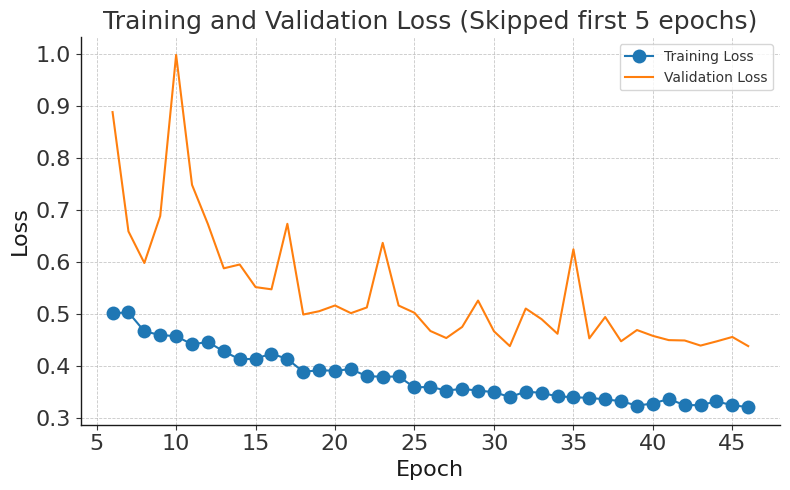

In [12]:
TRAIN = True
if TRAIN:
    custom_nn.seed_all()

    print("Training the model...")
    print('Model parameters:')
    for key, value in args.items():
        print(f"{key}: {value}")
    custom_nn.fit(dataset.X, dataset.y)
    # The dataset provided in fit is not used as the datasets are overwritten in the provided train_split function

    # Generate filename with current date
    current_date = datetime.now().strftime("%Y-%m-%d")
    model_filename = f"nn_model_{current_date}"

    plot_training_history(custom_nn, skip_first_n=5)

    # After Training: Best weights are already loaded
    # Save the model
    custom_nn.save_model(model_filename)
    
    # save params dic
    params_filename = f"nn_params_{current_date}.pkl"

    with open(f"models/{params_filename}", "wb") as f:
        pickle.dump(args, f)

Load previously trained model.

In [13]:
model_filename = "nn_model_2025-09-07_50%_kmeans_regional_baseline.pt"  # Replace with actual date if needed
loaded_model = mbm.models.CustomNeuralNetRegressor.load_model(
    cfg,
    model_filename,
    **{
        **args,
        **param_init
    },
)
loaded_model = loaded_model.set_params(device='cpu')
loaded_model = loaded_model.to('cpu')

### Model Evaluation & Prediction Analysis

**Comprehensive Evaluation Pipeline:**

1. **Prediction Generation:**
   - Individual sample predictions (`y_pred`)
   - Aggregated predictions by measurement ID (`y_pred_agg`)
   - Proper handling of multiple measurements per glacier

2. **Performance Metrics:**
   - **MAE (Mean Absolute Error):** Average prediction error magnitude
   - **RMSE (Root Mean Square Error):** Penalizes large prediction errors
   - **Pearson Correlation:** Linear relationship strength between predictions and observations
   - **R² Score:** Proportion of variance explained by the model

3. **Detailed Analysis:**
   - **Per-glacier performance:** Individual glacier prediction quality
   - **Temporal patterns:** Seasonal and annual prediction accuracy
   - **Geographic distribution:** Regional model performance variations

**Visualization Suite:**
- Combined prediction plots with confidence intervals
- Individual vs. predicted scatter plots with error statistics  
- Glacier-specific time series comparisons
- Error distribution analysis across measurement periods

In [14]:
# Create features and metadata
features_test, metadata_test = loaded_model._create_features_metadata(
    df_X_test_subset)

# Ensure all tensors are on CPU if they are torch tensors
if hasattr(features_test, 'cpu'):
    features_test = features_test.cpu()

# Ensure targets are also on CPU
targets_test = test_set['y']
if hasattr(targets_test, 'cpu'):
    targets_test = targets_test.cpu()

# Create the dataset
dataset_test = mbm.data_processing.AggregatedDataset(cfg,
                                                     features=features_test,
                                                     metadata=metadata_test,
                                                     targets=targets_test)

dataset_test = [
    SliceDataset(dataset_test, idx=0),
    SliceDataset(dataset_test, idx=1)
]

# Make predictions aggr to meas ID
y_pred = loaded_model.predict(dataset_test[0])
y_pred_agg = loaded_model.aggrPredict(dataset_test[0])

batchIndex = np.arange(len(y_pred_agg))
y_true = np.array([e for e in dataset_test[1][batchIndex]])

# Calculate scores
score = loaded_model.score(dataset_test[0], dataset_test[1])
mse, rmse, mae, pearson = loaded_model.evalMetrics(y_pred, y_true)

# Aggregate predictions
id = dataset_test[0].dataset.indexToId(batchIndex)
data = {
    'target': [e[0] for e in dataset_test[1]],
    'ID': id,
    'pred': y_pred_agg
}
grouped_ids = pd.DataFrame(data)

# Add period
periods_per_ids = df_X_test_subset.groupby('ID')['PERIOD'].first()
grouped_ids = grouped_ids.merge(periods_per_ids, on='ID')

# Add glacier name
glacier_per_ids = df_X_test_subset.groupby('ID')['GLACIER'].first()
grouped_ids = grouped_ids.merge(glacier_per_ids, on='ID')

# Add YEAR
years_per_ids = df_X_test_subset.groupby('ID')['YEAR'].first()
grouped_ids = grouped_ids.merge(years_per_ids, on='ID')

In [15]:
# Summary statistics by glacier for detailed analysis
print("\nDetailed Performance Summary by Glacier:")
glacier_stats = grouped_ids.groupby('GLACIER').agg({
    'target': ['count', 'mean', 'std'],
    'pred': ['mean', 'std']
}).round(4)

# Calculate RMSE and MAE per glacier
glacier_rmse = grouped_ids.groupby('GLACIER').apply(
    lambda x: np.sqrt(np.mean((x['target'] - x['pred'])**2))
).round(4)

glacier_mae = grouped_ids.groupby('GLACIER').apply(
    lambda x: np.mean(np.abs(x['target'] - x['pred']))
).round(4)

glacier_r2 = grouped_ids.groupby('GLACIER').apply(
    lambda x: 1 - np.sum((x['target'] - x['pred'])**2) / np.sum((x['target'] - x['target'].mean())**2)
).round(4)

glacier_rho = grouped_ids.groupby('GLACIER').apply(
    lambda x: x['target'].corr(x['pred'])
).round(4)

# Combine all metrics
performance_summary = pd.DataFrame({
    'N_samples': glacier_stats[('target', 'count')],
    'RMSE': glacier_rmse,
    'MAE': glacier_mae,
    'R²': glacier_r2,
    'Pearson': glacier_rho,
    'Target_mean': glacier_stats[('target', 'mean')],
    'Target_std': glacier_stats[('target', 'std')]
}).sort_values('RMSE')

print("Performance by glacier (sorted by RMSE):")
display(performance_summary)


Detailed Performance Summary by Glacier:
Performance by glacier (sorted by RMSE):


,N_samples,RMSE,MAE,R²,Pearson,Target_mean,Target_std
GLACIER,,,,,,,
Hoegtuvbreen,104,0.6572,0.5207,0.8488,0.9387,1.9032,1.6981
Vesledalsbreen,180,0.6612,0.4983,0.8328,0.9180,0.8077,1.6213
Trollbergdalsbreen,108,0.6899,0.5499,0.8240,0.9315,0.8719,1.6523
Ruklebreen,50,0.7092,0.5644,0.7886,0.8979,0.9378,1.5583
Breidablikkbrea,169,0.7516,0.5910,0.8606,0.9330,0.6381,2.0192
Graafjellsbrea,248,0.7796,0.6157,0.8611,0.9415,0.6290,2.0964
Hellstugubreen,25,0.8903,0.6198,0.7114,0.8721,-0.1788,1.6913
Svartisheibreen,83,1.0109,0.8243,0.7341,0.9005,0.7281,1.9723
Cainhavarre,52,1.0482,0.9171,-0.2227,0.7449,0.5598,0.9572


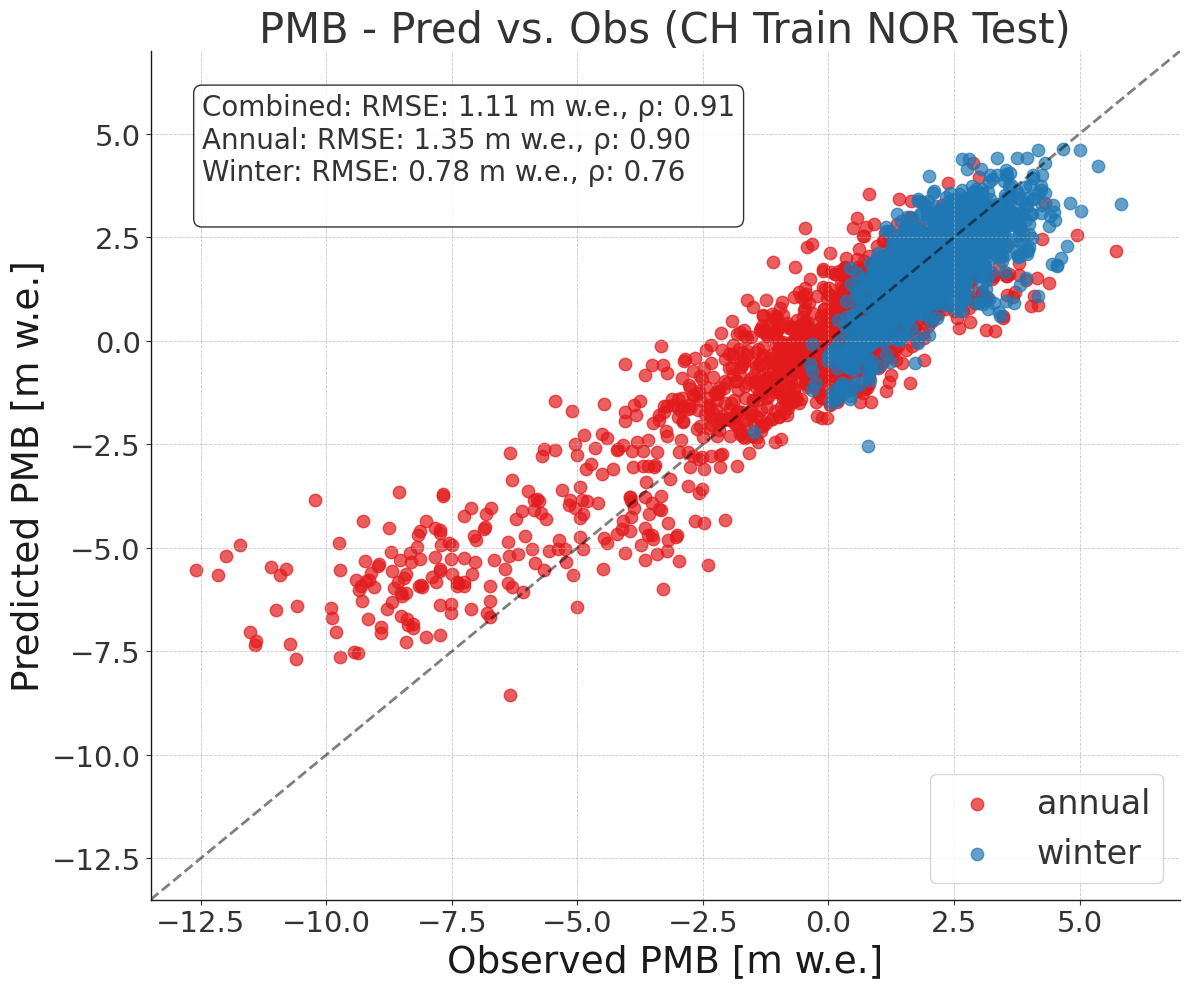

In [14]:
PlotPredictionsCombined_NN(grouped_ids, region_name='CH Train NOR Test', axis_limits=(-13.5, 7), tick_step=2.5)

Baseline RMSE: 1.1672


100%|██████████| 16/16 [17:15<00:00, 64.74s/it]


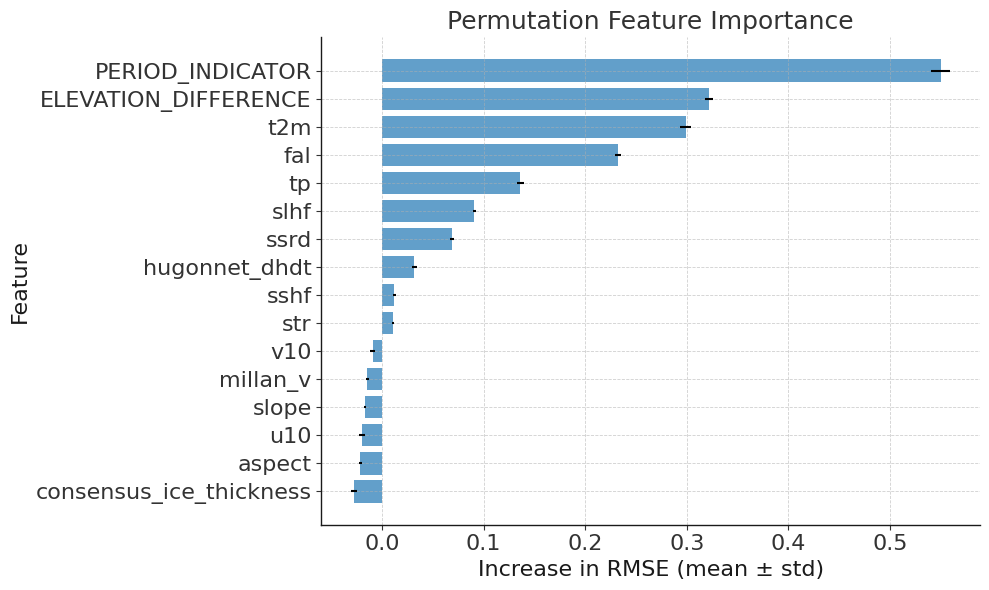

In [37]:
rng = np.random.default_rng(cfg.seed)
importances = {col: [] for col in feature_columns}

# Compute baseline
_, scores_baseline, _, _ = evaluate_model_and_group_predictions(
    loaded_model, df_X_test_subset, test_set['y'], cfg, mbm)

baseline_score = scores_baseline['rmse']
print(f"Baseline RMSE: {baseline_score:.4f}")

n_repeats = 10
for col in tqdm(feature_columns):
    for _ in range(n_repeats):
        df_permuted = df_X_test_subset.copy()
        df_permuted[col] = rng.permutation(df_permuted[col].values)

        # Evaluate model on permuted data
        _, scores_perm, _, _ = evaluate_model_and_group_predictions(
            loaded_model, df_permuted, test_set['y'], cfg, mbm)
        perm_score = scores_perm['rmse']
        importance = perm_score - baseline_score  # Positive = worse performance
        importances[col].append(importance)
        
# Aggregate results
df_importances = pd.DataFrame({
    "feature": feature_columns,
    "mean_importance": [np.mean(importances[col]) for col in feature_columns],
    "std_importance": [np.std(importances[col]) for col in feature_columns],
}).sort_values(by="mean_importance", ascending=False)

def plot_permutation_importance(df_importance, top_n=None, figsize=(10, 6), title="Permutation Feature Importance"):
    # Sort features by importance
    df_plot = df_importance.sort_values(by="mean_importance", ascending=True)
    if top_n:
        df_plot = df_plot.tail(top_n)

    plt.figure(figsize=figsize)
    plt.barh(
        df_plot["feature"],
        df_plot["mean_importance"],
        xerr=df_plot["std_importance"],
        align="center",
        alpha=0.7,
        ecolor="black",
        capsize=5
    )
    plt.xlabel("Increase in RMSE (mean ± std)")
    plt.ylabel("Feature")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()
    
plot_permutation_importance(df_importances, top_n=20)

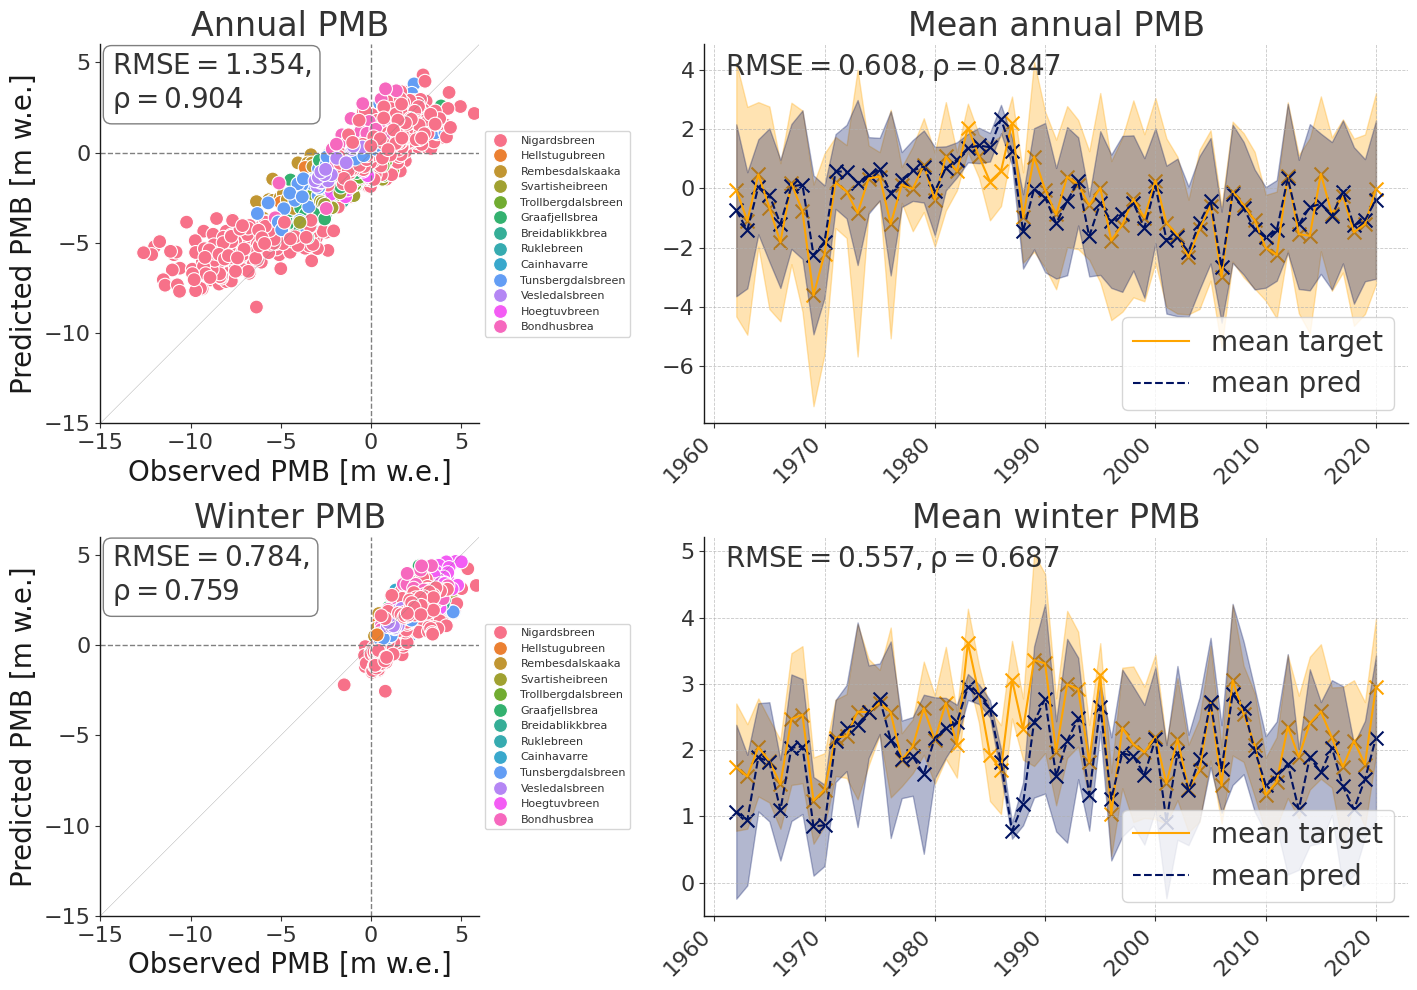

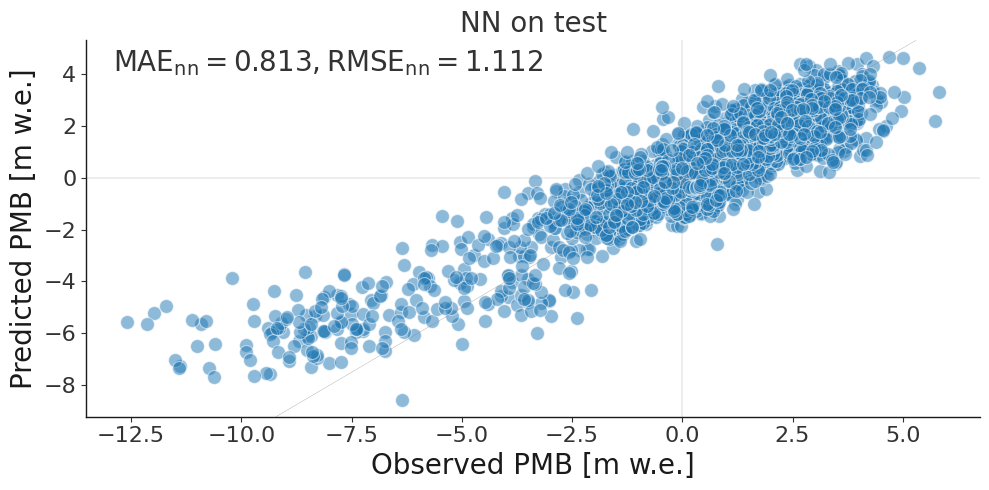

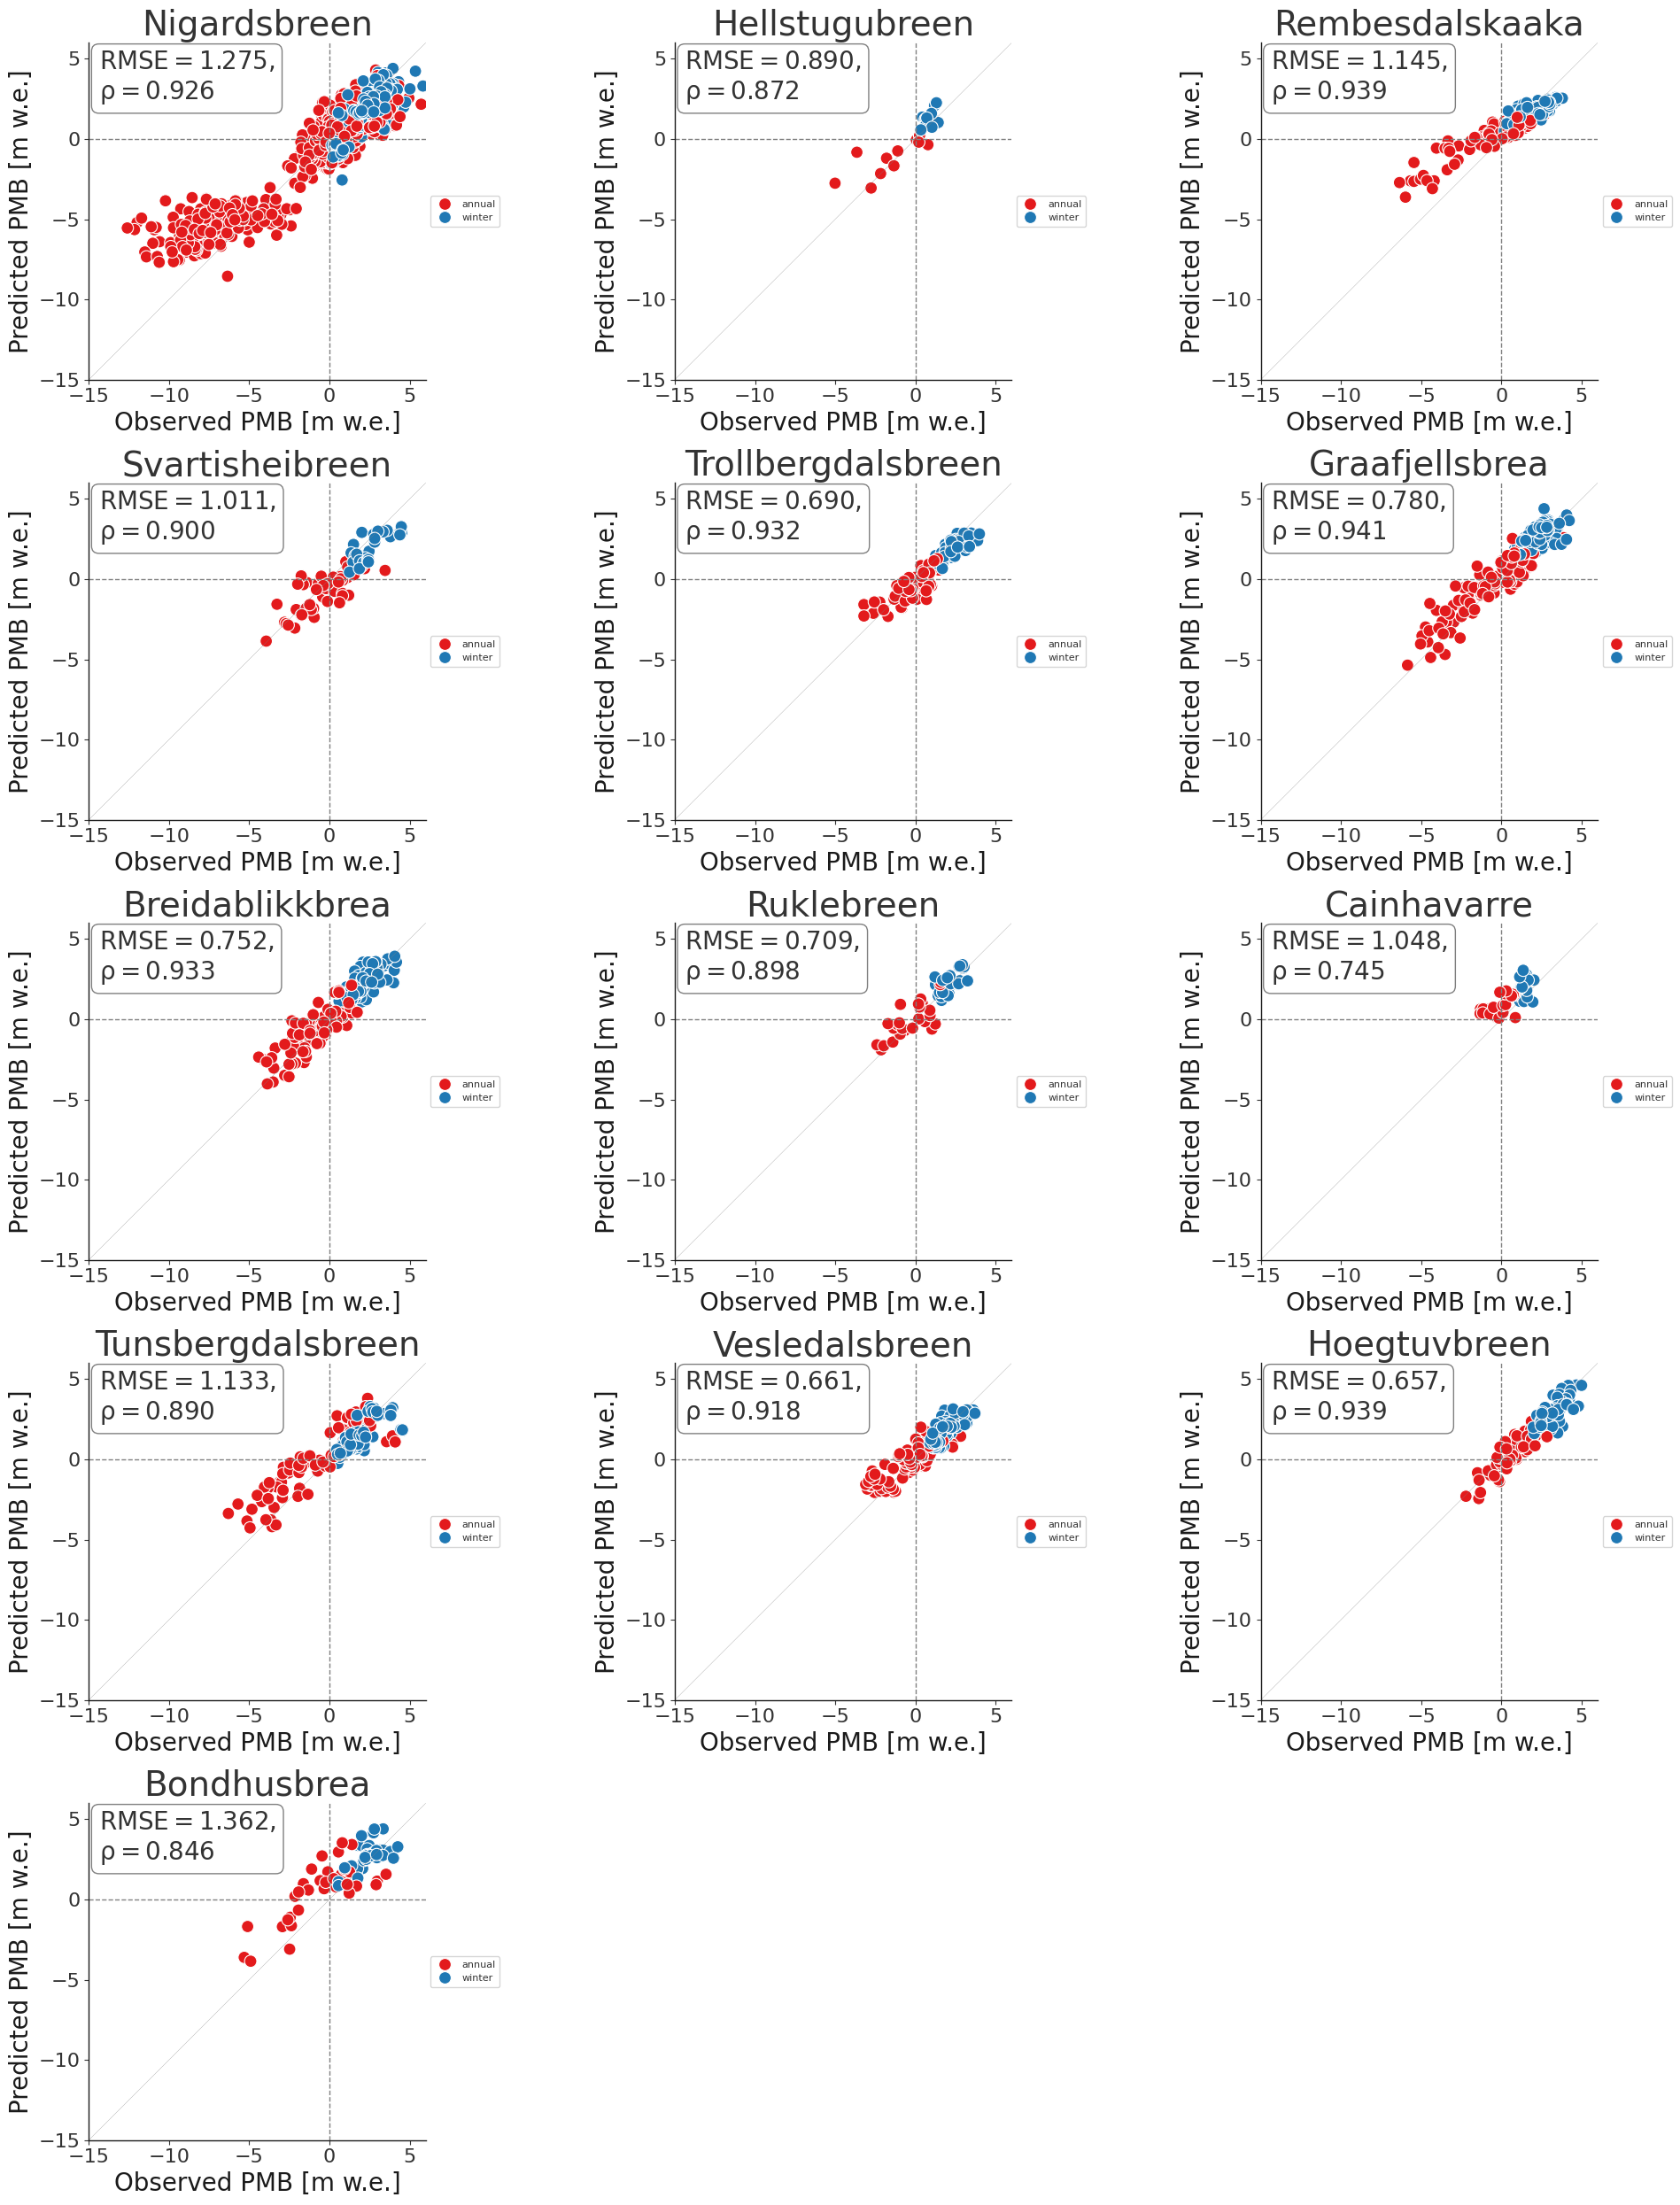

In [16]:
PlotPredictions_NN(grouped_ids)
predVSTruth_all(grouped_ids, mae, rmse, title='NN on test')
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))